In [35]:
import numpy as np
from keras.models import Model
from keras.layers import Dense,BatchNormalization,Conv1D
from keras.layers import Input,GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.optimizers import Adam
import keras.backend as K

from utils import generate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
import datetime
from keras.callbacks import History
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model

from keras.applications.xception import preprocess_input

In [13]:
model = load_model('models/30_new_model.h5')

In [14]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 29, 1)        0                                            
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 29, 32)       96          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 29, 32)       96          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 29, 32)       128         input_3[0][0]                    
____________________________________________________________________________________________

In [134]:
def make_gradcam_heatmap(track, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
#     print(model.get_layer(last_conv_layer_name).output)
#     print(model.output)
#     print(model.input)
# #     deep_inputs = tf.keras.Input(tensor=(inputs))
#     print(tf.convert_to_tensor(track))
    grad_model = Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(tf.cast(tf.convert_to_tensor(track), tf.float32))
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]
    
#     print(K.eval(class_channel))
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tf.gradients(class_channel, last_conv_layer_output)
    
#     print(K.eval(grads[0]))
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap

In [154]:
# Prepare track
# preprocess_input = keras.applications.xception.preprocess_input
track =np.loadtxt("em18tracks.txt")[1]
track = preprocess_input(track[None,:, None])

print(track)
# Remove last layer's softmax
model.layers[-1].activation = None

# # Print what the top predicted class is
index_to_type = {0: "fbm", 1: "brownian", 2: "ctrw"}

preds = model.predict(track)
print(preds)
print("Predicted:", index_to_type[np.argmax(preds)])

# # Generate class activation heatmap
heatmap = make_gradcam_heatmap(track, model, "conv1d_50")

arr = K.eval(heatmap)
# # Display heatmap
# plt.matshow(heatmap)
plt.show()

[[[-0.917]
  [-1.063]
  [-0.971]
  [-1.020]
  [-1.010]
  [-0.982]
  [-0.999]
  [-1.003]
  [-0.996]
  [-0.991]
  [-1.010]
  [-0.988]
  [-0.995]
  [-0.992]
  [-1.018]
  [-0.973]
  [-1.035]
  [-1.067]
  [-0.899]
  [-1.072]
  [-0.951]
  [-0.977]
  [-1.050]
  [-0.957]
  [-1.025]
  [-0.949]
  [-1.047]
  [-0.990]
  [-1.017]]]
[[0.001 0.995 0.004]]
Predicted: brownian


In [143]:
def _plot_score(vec, xticks):
    _axis_fontsize=8
    fig=plt.figure(figsize = (20,10))
    plt.yticks([])
#     float_formatter = "{:.3f}".format
#     np.set_printoptions(formatter={'float_kind':float_formatter})
#     print(xticks)
    plt.xticks(range(0,len(vec)), xticks, fontsize=_axis_fontsize)
    fig.add_subplot(1, 1, 1)
    plt.figtext(x=0.13, y=0.54, s = "Hi",fontsize=5, fontname='sans-serif')
    img = plt.imshow([vec], vmin=0, vmax=1)
    plt.show()

C:\Users\eric_\Anaconda3\envs\MoNet\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


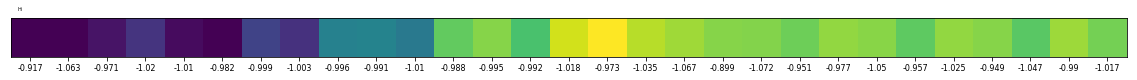

In [144]:
_plot_score(arr, np.around(track.flatten(), decimals=3))

In [145]:
print(arr)

[0.000 0.000 0.054 0.150 0.031 0.001 0.202 0.143 0.439 0.448 0.403 0.758
 0.820 0.715 0.931 1.000 0.891 0.857 0.819 0.816 0.779 0.838 0.823 0.753
 0.836 0.817 0.745 0.854 0.793]


In [146]:
print(track.flatten())

[-0.917 -1.063 -0.971 -1.020 -1.010 -0.982 -0.999 -1.003 -0.996 -0.991
 -1.010 -0.988 -0.995 -0.992 -1.018 -0.973 -1.035 -1.067 -0.899 -1.072
 -0.951 -0.977 -1.050 -0.957 -1.025 -0.949 -1.047 -0.990 -1.017]
